In [71]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import joblib

# 1. Data Loading and Preparation
def load_time_series_data():
    """Load data where each test has one time series of temperatures"""
    summary_df = pd.read_csv('all_time.csv')
    test_data = []
    
    for i in range(1, 26):
        try:
            filename = f'csv_ave/{i}.csv'
            df = pd.read_csv(filename, header=1)
            test_params = summary_df.iloc[i-1][['Fb_set\n[kN]', 'v_set\n[km/h]', 'μ_m', 't2\n[s]']].values
            temperature_series = df.iloc[:, 3].values
            
            test_data.append({
                'Fb_set': test_params[0],
                'v_set': test_params[1],
                'μ_m': test_params[2],
                't2': test_params[3],
                'temperature_series': temperature_series
            })
        except FileNotFoundError:
            continue
    
    return test_data

def resample_series(temp_series, original_length, target_length=100):
    """Resample time series to target length using linear interpolation"""
    original_time = np.linspace(0, 1, original_length)
    target_time = np.linspace(0, 1, target_length)
    return np.interp(target_time, original_time, temp_series)

# Load and preprocess data
test_data = load_time_series_data()
TARGET_LENGTH = 1500  # Fixed length for all series

X = []
y = []

for test in test_data:
    # Input features
    X.append([test['Fb_set'], test['v_set'], test['μ_m'], test['t2']])
    
    # Resample temperature series
    original_length = len(test['temperature_series'])
    resampled = resample_series(
        test['temperature_series'],
        original_length,
        TARGET_LENGTH
    )
    y.append(resampled)

X = np.array(X)
y = np.array(y)



In [72]:
print(X.shape)
print(y.shape)

(11, 4)
(11, 1500)


In [73]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Normalization
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# 2. Model Definition
def build_model():
    inputs = keras.Input(shape=(4,))  # 4 input features
    
    # Feature extraction
    params = layers.Dense(64, activation='relu')(inputs)
    params = layers.Dropout(0.2)(params)
    
    # Repeat for time steps
    repeated = layers.RepeatVector(TARGET_LENGTH)(params)
    
    # Temporal processing
    lstm_out = layers.LSTM(64, return_sequences=True)(repeated)
    outputs = layers.TimeDistributed(layers.Dense(1))(lstm_out)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        metrics=['mae']
    )
    return model

model = build_model()
model.summary()

# 3. Training Configuration
callbacks = [
    EarlyStopping(patience=100, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# 4. Training
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=1)

# 5. Evaluation
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# 6. Save artifacts
model.save('brake_temp_model.keras')
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 1500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1500, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1500, 1)        │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,409 (130.50 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.9944 - mae: 0.8548

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.9944 - mae: 0.8548 - val_loss: 0.2292 - val_mae: 0.4062
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4060 - mae: 0.4687 - val_loss: 0.5957 - val_mae: 0.6559
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3806 - mae: 0.4664 - val_loss: 0.2771 - val_mae: 0.3221
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2304 - mae: 0.3631

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2304 - mae: 0.3631 - val_loss: 0.1853 - val_mae: 0.3024
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2655 - mae: 0.3772 - val_loss: 0.2216 - val_mae: 0.3845
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1339 - mae: 0.2368 - val_loss: 0.2195 - val_mae: 0.3808
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1396 - mae: 0.2325

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1396 - mae: 0.2325 - val_loss: 0.1843 - val_mae: 0.2956
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1471 - mae: 0.2531 - val_loss: 0.1946 - val_mae: 0.1942
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1641 - mae: 0.2754 - val_loss: 0.2388 - val_mae: 0.2470
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1556 - mae: 0.2647 - val_loss: 0.2488 - val_mae: 0.2664
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1479 - mae: 0.2557 - val_loss: 0.2205 - val_mae: 0.2131
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1320 - mae: 0.2265 - val_loss: 0.1858 - val_mae: 0.2175
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1597 - mae: 0.2645

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1597 - mae: 0.2645 - val_loss: 0.1804 - val_mae: 0.2614
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1850 - mae: 0.3282 - val_loss: 0.1810 - val_mae: 0.2461
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1447 - mae: 0.2634 - val_loss: 0.1854 - val_mae: 0.2206
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1311 - mae: 0.2263 - val_loss: 0.1954 - val_mae: 0.1952
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1245 - mae: 0.1970 - val_loss: 0.1972 - val_mae: 0.1921
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1339 - mae: 0.1992 - val_loss: 0.1898 - val_mae: 0.2082
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1277 - mae: 0.1930 - val_loss: 0.1830 - val_mae: 0.2333
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1330 - mae: 0.2369 - val_loss: 0.1813 - val_mae: 0.2689
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1351 - mae: 0.2330 - val_loss: 0.1827 - va

['scaler_y.pkl']

/Users/yanjun/Documents/apps/miniconda3/envs/dd2421/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 9 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


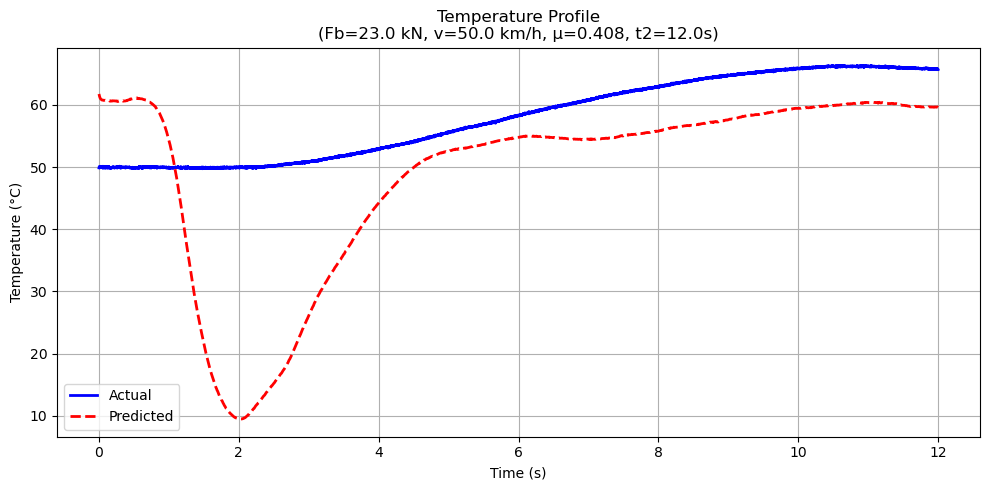

In [74]:
# 7. Prediction and Visualization
def predict_temperature_series(Fb_set, v_set, mu_m, t2):
    """Predict resampled temperature series"""
    model = keras.models.load_model('brake_temp_model.keras')
    scaler_X = joblib.load('scaler_X.pkl')
    scaler_y = joblib.load('scaler_y.pkl')
    
    input_data = scaler_X.transform(np.array([[Fb_set, v_set, mu_m, t2]]))
    prediction = model.predict(input_data)
    return scaler_y.inverse_transform(prediction.reshape(1, -1))[0]

def plot_comparison(Fb_set, v_set, mu_m, t2):
    """Compare actual vs predicted with correct time scaling"""
    # Get prediction
    pred = predict_temperature_series(Fb_set, v_set, mu_m, t2)
    
    # Find matching test data
    actual_series = None
    for test in test_data:
        if (np.isclose(test['Fb_set'], Fb_set) and
            np.isclose(test['v_set'], v_set) and
            np.isclose(test['μ_m'], mu_m) and
            np.isclose(test['t2'], t2)):
            actual_series = test['temperature_series']
            break
    
    # Create time axes
    pred_time = np.linspace(0, t2, TARGET_LENGTH)
    if actual_series is not None:
        actual_time = np.linspace(0, t2, len(actual_series))
    
    # Plot
    plt.figure(figsize=(10, 5))
    if actual_series is not None:
        plt.plot(actual_time, actual_series, 'b-', label='Actual', linewidth=2)
    plt.plot(pred_time, pred, 'r--', label='Predicted', linewidth=2)
    
    plt.title(f'Temperature Profile\n(Fb={Fb_set} kN, v={v_set} km/h, μ={mu_m}, t2={t2}s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
if len(test_data) > 0:
    sample = test_data[0]
    plot_comparison(
        sample['Fb_set'],
        sample['v_set'],
        sample['μ_m'],
        sample['t2']
    )

/Users/yanjun/Documents/apps/miniconda3/envs/dd2421/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 9 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


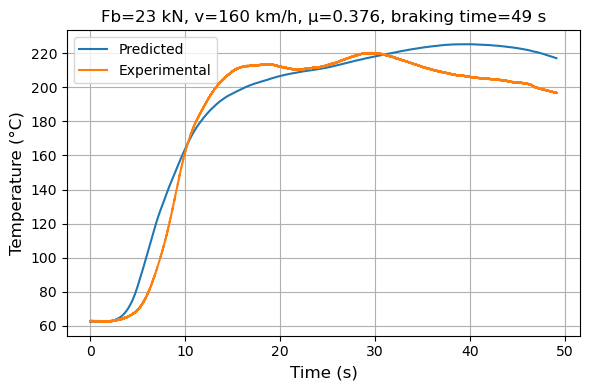

In [75]:
font = 12
plt.figure(figsize=(6, 4))

pred = predict_temperature_series(23,160,0.376,49.1)
time_pred = np.arange(len(pred)) * (49.1/TARGET_LENGTH)
plt.plot(time_pred, pred, label='Predicted')


pd1 = pd.read_csv('4.csv')
T_expe = np.array( pd1['ave'])
time_exe = np.arange(len(T_expe) ) * (49.1/ len(T_expe))
plt.plot(time_exe, T_expe, label='Experimental' )

plt.title(f'Fb=23 kN, v=160 km/h, μ=0.376, braking time=49 s')
plt.xlabel('Time (s)', fontsize = font)
plt.ylabel('Temperature (°C)',fontsize = font)
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('machine.pdf')

/Users/yanjun/Documents/apps/miniconda3/envs/dd2421/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 9 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
RMSE: 13.20 °C


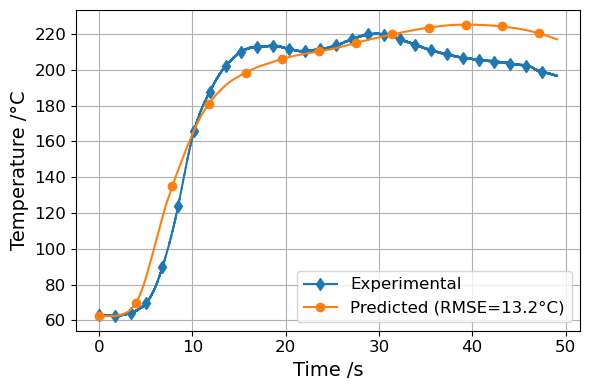

In [77]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 1. Get predictions and experimental data
pred = predict_temperature_series(23, 160, 0.376, 49.1)
pd1 = pd.read_csv('4.csv')
T_expe = np.array(pd1['ave'])

# 2. Resample experimental data to match prediction length
def resample_to_target(original_series, original_length, target_length):
    """Resample using linear interpolation"""
    original_time = np.linspace(0, 1, original_length)
    target_time = np.linspace(0, 1, target_length)
    return np.interp(target_time, original_time, original_series)

T_expe_resampled = resample_to_target(
    T_expe, 
    len(T_expe), 
    len(pred)
)

# 3. Calculate RMSE
rmse = np.sqrt(mean_squared_error(pred, T_expe_resampled))
print(f"RMSE: {rmse:.2f} °C")

# 4. Add to plot
plt.figure(figsize=(6, 4))
time_expe = np.arange(len(T_expe)) * (49.1/len(T_expe))
plt.plot(time_expe, T_expe, label='Experimental',marker='d',markevery=1000)

time_pred = np.arange(len(pred)) * (49.1/len(pred))
plt.plot(time_pred, pred, label=f'Predicted (RMSE={rmse:.1f}°C)',marker='o', markevery=120)

glb = 14

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Fb=23 kN, v=160 km/h, μ=0.376, braking time=49 s')
plt.xlabel('Time /s', fontsize=glb)
plt.ylabel('Temperature /°C', fontsize=glb)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
#plt.savefig('machine.pdf')

2025-6-19, until now, the best RMSE is 13.2